In [233]:
#Importing libraries that are going to be used further in our notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [480]:
df = pd.read_csv('/Users/Mansi/Documents/INF1340H/Final Project/Black_Friday.csv',low_memory=False)

**A. Data Cleaning (10%)**
First, you need to clean the data. The existing dataset has missing values in some columns, and also some continuous or discrete ordinal columns are treated as string (object) because they include special characters like +.
Write a function clean_data that takes in a DataFrame as an input, and returns a clean DataFrame. The clean DataFrame should follow these rules: clean_data(df) -> clean_df
1. This function needs to turn ordinal columns into column with a proper data type. If a column like age or stay_in_current_city_years represents an ordinal feature (discrete numeric), it should be a number instead of a string object.
2. This functions needs to turn any categorical column containing numbers into strings. For example, a column including IDs should be a string data type instead of numeric data type (because there is no order for IDs).
3. This function needs to handle missing values. It should either fill missing values with proper value, or drop the entire column containing too many missing values.

In [481]:
df

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
...,...,...,...,...,...,...,...,...,...,...,...,...
497991,1004653,P00293342,M,36-45,12,B,3,1,8,NaN,NaN,5824
497992,1004654,P00108542,M,36-45,20,C,3,0,5,8.0,14.0,8580
497993,1004654,P00051442,M,36-45,20,C,3,0,8,17.0,NaN,9828
497994,1004654,P00272042,M,36-45,20,C,3,0,8,14.0,NaN,9977


**Handing ordinal columns**

Age
0-17      13653
18-25     90611
26-35    198633
36-45     99620
46-50     41180
51-55     34922
55+       19377
dtype: int64

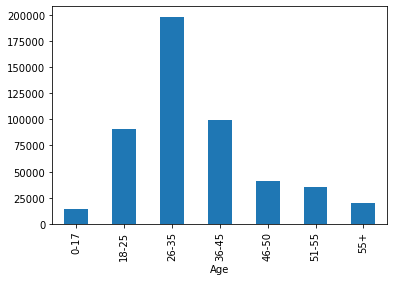

In [482]:
# Plotting bar plot for Age.
Agegrp = df.groupby('Age')
Agegrp.size().plot(kind='bar')
Agegrp.size()

**AGE**


</n>There is lot of variance in the count of transactions in different age categories. This can impact data modeling and model efficiency later. So the age groups will be re-categorized in the following way to reduce the variance to some extent and then converted to type int.
1. 0-17 + 18-25        --> category 0
2. 26-35               --> category 1
3. 36-45               --> category 2
4. 46-50 + 51-55 + 55+ --> category 3

In [483]:
# function to assign new categories to Age and store the new categories in a new column 'New_AgeGrp'.
def recategorizeAge(df):
    for i in range(len(df)):
            age = df.iloc[i]["Age"]
            if((age == '0-17') | (age == '18-25')):
                df.at[i, 'New_AgeGrp'] = 0
            elif(age == '26-35'):
                df.at[i, 'New_AgeGrp'] = 1
            elif(age == '36-45'):
                df.at[i, 'New_AgeGrp'] = 2
            elif((age == '51-55') | (age == '46-50') | (age == '55+')):
                df.at[i, 'New_AgeGrp'] = 3
    return(df)

Stay_In_Current_City_Years
0      67413
1     175189
2      92185
3      86308
4+     76901
dtype: int64

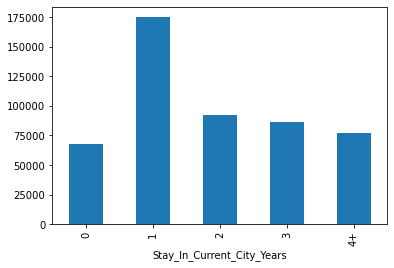

In [484]:
# Plotting bar plots for Stay_In_Current_City_Years
yrsgrp = df.groupby('Stay_In_Current_City_Years')
yrsgrp.size().plot(kind='bar')
yrsgrp.size()

**Stay_In_Current_City_Years**

Stay_In_Current_City_Years will be categorized as follows:
1. 0 --> 0
2. 1 --> 1
3. 2 --> 2
4. 3 --> 3
5. 4+ --> 4

In [485]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497996 entries, 0 to 497995
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     497996 non-null  int64  
 1   Product_ID                  497996 non-null  object 
 2   Gender                      497996 non-null  object 
 3   Age                         497996 non-null  object 
 4   Occupation                  497996 non-null  int64  
 5   City_Category               497996 non-null  object 
 6   Stay_In_Current_City_Years  497996 non-null  object 
 7   Marital_Status              497996 non-null  int64  
 8   Product_Category_1          497996 non-null  int64  
 9   Product_Category_2          343246 non-null  float64
 10  Product_Category_3          152172 non-null  float64
 11  Purchase                    497996 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 45.6+ MB


**Product_Category_1/2/3**

df.info() shows that there are two columns which have missing/null values - Product_Category_1, Product_Category_2.

As Product_Category_1/2/3 represent the number of purchased products in that category, it is **assumed that missing/null values in these columns in any transaction means that no item was purchased in that category and hence will be replaced by 0 in clean_data() function.**

In [486]:
def clean_data(data):
    
    data = recategorizeAge(data)    # Calling function to recategorize Age column
    
    data['User_ID'] = data['User_ID'].astype(str)  # Converting User_ID to string data type    
    data['Occupation'] = data['Occupation'].astype(str)  # Converting Occupation column to string data type    
    data['Marital_Status'] = data['Marital_Status'].astype(str)  # Converting Marital_Status column to string data type
    data['New_AgeGrp'] = data['New_AgeGrp'].astype(int)  # Converting New_AgeGrp column to type int 
    
    data['Product_Category_2'].fillna(0, inplace = True)  # Filling null/missing values with 0
    data['Product_Category_3'].fillna(0, inplace = True)  # Filling null/missing values with 0
    data['Product_Category_2'] = data['Product_Category_2'].astype(int)  # Changing data type to int
    data['Product_Category_3'] = data['Product_Category_3'].astype(int)  # Changing data type to int
    
    # Categorizing Stay_In_Current_City_Years column and storing the new categories in a new column Stay_In_Current_City_Year
    data.Stay_In_Current_City_Years = pd.Categorical(data.Stay_In_Current_City_Years)  
    data['Stay_In_Current_City_Year'] = data.Stay_In_Current_City_Years.cat.codes
    
    data = data.drop(['Age'],axis=1)
    data = data.drop(['Stay_In_Current_City_Years'],axis=1)
    
    return(data)

In [487]:
clean_df = clean_data(df)

In [488]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497996 entries, 0 to 497995
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   User_ID                    497996 non-null  object
 1   Product_ID                 497996 non-null  object
 2   Gender                     497996 non-null  object
 3   Occupation                 497996 non-null  object
 4   City_Category              497996 non-null  object
 5   Marital_Status             497996 non-null  object
 6   Product_Category_1         497996 non-null  int64 
 7   Product_Category_2         497996 non-null  int64 
 8   Product_Category_3         497996 non-null  int64 
 9   Purchase                   497996 non-null  int64 
 10  New_AgeGrp                 497996 non-null  int64 
 11  Stay_In_Current_City_Year  497996 non-null  int8  
dtypes: int64(5), int8(1), object(6)
memory usage: 42.3+ MB


### B. Data Analysis (30% + 10%)**

#### Using clean DataFrame from previous section answer questions below by visualizing proper plots:


#### 1. Compare number of customers, and total amount of purchase for each gender? Is this a balance dataset with respect to gender? (5%)

**Number of customers in each gender**

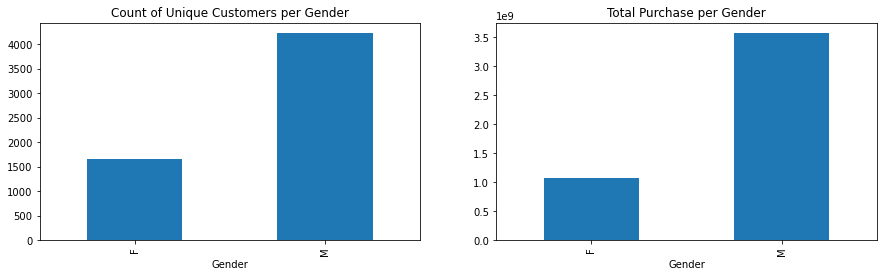

Number of unique customers for Males:  4225
Number of unique customers for Females:  1666
Total Amount of purchase for Males:  3568533248
Total Amount of purchase for Females:  1078358205


In [489]:
fig, axes = plt.subplots(figsize=(15,4),nrows=1, ncols=2)
clean_df.groupby('Gender')['User_ID'].nunique().plot(kind='bar', title= "Count of Unique Customers per Gender", ax=axes[0] )
clean_df.groupby('Gender')['Purchase'].agg('sum').plot(kind='bar', title= "Total Purchase per Gender", ax=axes[1])
plt.show()
print("Number of unique customers for Males: ", clean_df[clean_df["Gender"]== "M"]["User_ID"].nunique())
print("Number of unique customers for Females: ", clean_df[clean_df["Gender"]== "F"]["User_ID"].nunique())
print("Total Amount of purchase for Males: ", clean_df[clean_df["Gender"]== "M"]["Purchase"].sum())
print("Total Amount of purchase for Females: ", clean_df[clean_df["Gender"]== "F"]["Purchase"].sum())

From the above figures it can be seen that number of Male customers are more than Female customers. Also total purchase amount for Males is almost 3 times more than that of Females. This dataset is **not a balanced dataset with respect to Gender**

### 2. Compare total amount of purchase for different cities. (5%)

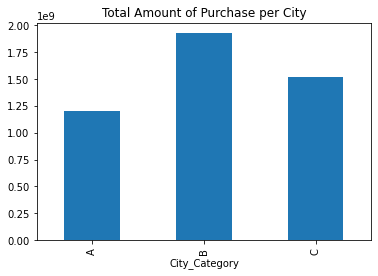

Total Amount of purchase for City A:  1200686706
Total Amount of purchase for City B:  1928963340
Total Amount of purchase for City C:  1517241407


In [490]:
clean_df.groupby('City_Category')['Purchase'].agg('sum').plot(kind='bar', title= "Total Amount of Purchase per City")
plt.show()
print("Total Amount of purchase for City A: ", clean_df[clean_df["City_Category"]== "A"]["Purchase"].sum())
print("Total Amount of purchase for City B: ", clean_df[clean_df["City_Category"]== "B"]["Purchase"].sum())
print("Total Amount of purchase for City C: ", clean_df[clean_df["City_Category"]== "C"]["Purchase"].sum())

**Amongst the three cities, the total amount of purchase is maximum in City B and minimum in City A.**

#### 3. Compare total amount of purchase for combinations of gender and age. Which gender and age is better target for marketing campaign? (5%)

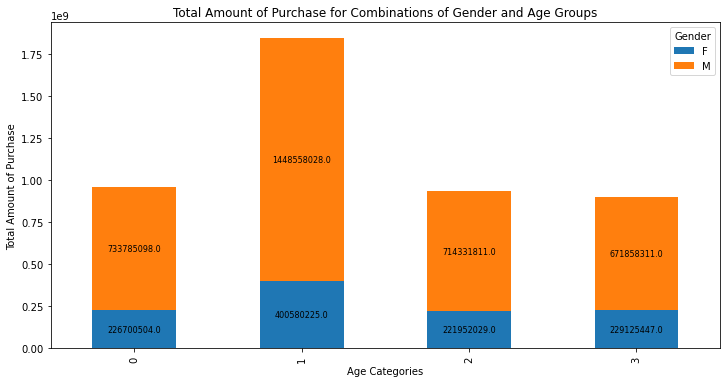

In [491]:
data = clean_df.groupby(['New_AgeGrp','Gender'])['Purchase'].agg('sum').unstack(level=-1)
ax = data.plot.bar(stacked=True, figsize=(12, 6))
ax.set_ylabel('Total Amount of Purchase')
ax.set_xlabel('Age Categories')
ax.set_title('Total Amount of Purchase for Combinations of Gender and Age Groups')
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = f'{height}'  # f'{height:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2

    # plot only when height is greater than specified value
    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)

Compare total amount of purchase for combinations of gender and age. Which gender and age is better target for marketing campaign? (5%)

The above graph shows that 
1. **Total amount of purchase for age category 1 (26-35) is much more than the other age categories.** 
2. **Males purchased more than three times than females in all age categories.**
3. **It is thus concluded that Males aged between 26-35 are the highest spenders.**

#### 4. Using box and whisker plot, compare distribution of purchase amounts among combinations of genders and age. (5%)

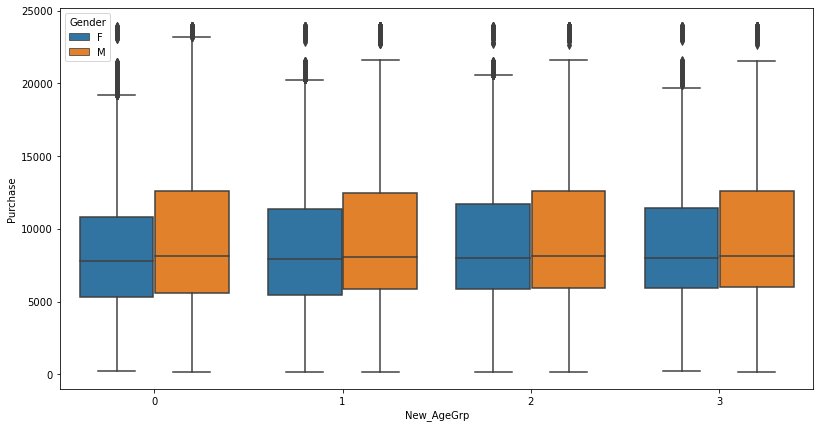

In [492]:
plt.figure(figsize=(13.5, 7))
sns.boxplot(x="New_AgeGrp", y="Purchase", hue="Gender", data=clean_df)

**Observations** from the above figure:
1. The lower whiskers, 1st quartiles and medians are almost same in all the figures. This means that 25% of males and females in all the age groups spent upto 5K only. Another 25% of males and females in all age groups spent between 5K and 6K. 
2. The 3rd quartiles of males are more than those of females in all age groups. This means that the range of purchase amounts for 25% of males and females lying in 3rd quartiles is more for males.
3. Within the same gender the 3rd quartiles are almost same. 
4. The maximum purchase amount for males and females is almost same in all age categories. 

### 5. Using box and whisker plot, compare distribution of purchase amounts among different occupations. (5%)

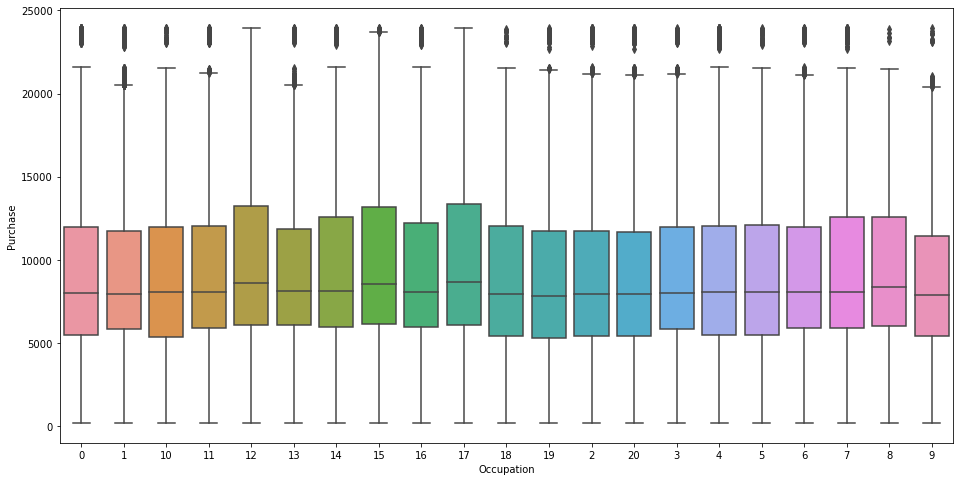

In [493]:
plt.figure(figsize=(16, 8))
sns.boxplot(x="Occupation", y="Purchase", data=clean_df )

**Observations**
1. The median and maximum purchase values for customers in all occupations is almost same
2. Customers with 12, 15 and 17 categories of occupation spend more
3. Customers under occupation category 9 spend the least


6. (Optional) Create a heatmap or scatter plot showing correlation matrix of all of two numerical features. Which features are positively correlated with purchase amount? (+10%)

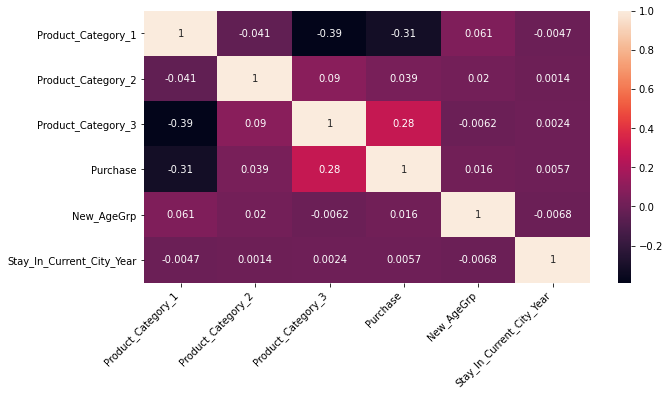

In [494]:
fig, ax = plt.subplots(figsize=(10,5))
corr = clean_df.corr()
ax = sns.heatmap(
    corr,annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**Product_Category_2, Product_Category_3, Age group and Stay_In_Current_City_Years are positively correlated with Purchase amount**

### C. Data Modeling (60% + 5%)

#### 1. Feature Engineering: In this part, you need to preprocess and engineer features (columns) to be able to feed it to regression model and predict purchase amount better.

    a. For categorical columns, use dummy variable to turn categorical column into columns of binary values (one-hot encoded vector) (15%)

Following columns are categorical columns which will be processed to get their dummies:


*Gender


*Occupation


*City_Category


*Stay_In_Current_Year


*Marital_Status


*New_AgeGrp

In [495]:
clean_df_encoded = pd.concat([clean_df,pd.get_dummies(clean_df['Gender'], prefix='Gender')],axis=1).drop(['Gender'],axis=1)
clean_df_encoded = pd.concat([clean_df_encoded,pd.get_dummies(clean_df_encoded['Occupation'], prefix='Occupation')],axis=1).drop(['Occupation'],axis=1)
clean_df_encoded = pd.concat([clean_df_encoded,pd.get_dummies(clean_df_encoded['City_Category'], prefix='City_Category')],axis=1).drop(['City_Category'],axis=1)
clean_df_encoded = pd.concat([clean_df_encoded,pd.get_dummies(clean_df_encoded['Stay_In_Current_City_Year'], prefix='Stay_In_Current_City_Year')],axis=1).drop(['Stay_In_Current_City_Year'],axis=1)
clean_df_encoded = pd.concat([clean_df_encoded,pd.get_dummies(clean_df_encoded['New_AgeGrp'], prefix='Age')],axis=1).drop(['New_AgeGrp'],axis=1)
clean_df_encoded = pd.concat([clean_df_encoded,pd.get_dummies(clean_df_encoded['Marital_Status'], prefix='Marital_Status')],axis=1).drop(['Marital_Status'],axis=1)

In [496]:
# dropping User_ID and Product_ID columns as they are just unqique IDs and not useful for prediction of Purchase
clean_df_encoded = clean_df_encoded.drop(['User_ID'], axis=1)
clean_df_encoded = clean_df_encoded.drop(['Product_ID'], axis=1)

In [497]:
#Moving Purchase column to the end of the dataframe
clean_df_encoded = clean_df_encoded.drop(columns=['Purchase']).assign(Purchase=clean_df_encoded['Purchase'])

#### 2. Linear Regression Model: split the dataset into training and testing dataset (80% for training and 20% for testing). Next, create and fit a multivariant linear regression model to training dataset. Then, test the trained model over testing dataset. What are the MAE and MSE? Feel free to modify or tune anything you want in previous parts to reduce MAE and MSE. (30%)

In [635]:
Input = clean_df_encoded.iloc[:,0:40] # Selecting all columns as Input to the Model except Purchase
Target = clean_df_encoded.iloc[:,40] # Selecting Purchase as Target variable

#Splitting data into train and test data. 20% data is kept for test data
X_train, X_test, Y_train, Y_test = train_test_split(Input, Target, test_size=0.2, random_state=0) 

**II) (Optional) Normalize all numerical columns using mean normalization. (+5%)**

In [636]:
X_train = (X_train - X_train.mean())/(X_train.max()-X_train.min()) #Normalizing Train data
X_test = (X_test - X_test.mean())/(X_test.max()-X_test.min())   ##Normalizing Test data

In [637]:
regr = LinearRegression()
regr.fit(X_train, Y_train) # Fitting Linear Regression model on the train data
y_pred = regr.predict(X_test) # Predicting Purchase values for the test data

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)

output = {'MSE': mse, 'MAE' : mae}
print("The MSE and MAE are: ", output)

The MSE and MAE are:  {'MSE': 22149276.953706007, 'MAE': 3617.5969831701923}


In [501]:
print('Intercept parameter:', regr.intercept_)
coeff_df = pd.DataFrame(regr.coef_, Input.columns, columns=['Coefficient'])
print(coeff_df)

Intercept parameter: 9371.40368425945
                              Coefficient
Product_Category_1          -5.377741e+03
Product_Category_2          -6.964032e+02
Product_Category_3           2.873701e+03
Gender_F                    -1.681120e+18
Gender_M                    -1.681120e+18
Occupation_0                 6.910652e+15
Occupation_1                 6.910652e+15
Occupation_10                6.910652e+15
Occupation_11                6.910652e+15
Occupation_12                6.910652e+15
Occupation_13                6.910652e+15
Occupation_14                6.910652e+15
Occupation_15                6.910652e+15
Occupation_16                6.910652e+15
Occupation_17                6.910652e+15
Occupation_18                6.910652e+15
Occupation_19                6.910652e+15
Occupation_2                 6.910652e+15
Occupation_20                6.910652e+15
Occupation_3                 6.910652e+15
Occupation_4                 6.910652e+15
Occupation_5                 6.910652e

#### More data cleaning to see if model efficiency improves

Checked for outliers in all columns and found some in Purchase column

In [572]:
clean_df2 = clean_df_encoded.copy()

In [573]:
q75, q25 = np.percentile(clean_df2.Purchase, [75,25])
iqr = q75 - q25
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(q25, q75,iqr, lower,upper )

5865.0 12071.0 6206.0 -3444.0 21380.0


In [574]:
# Function to update status of each record as faulty, working fine or need maintenance
def update_status(lower):
        for i in range(len(clean_df2)):
            purchase = clean_df2.iloc[i]["Purchase"]
            if(purchase > upper):
                clean_df2.at[i, 'Status'] = "Outlier"
            else:
                clean_df2.at[i, 'Status'] = "Inlier"

In [575]:
update_status(lower)

In [580]:
print(clean_df2.Status.value_counts())
print("Less than 1% of values in Purchase column are found to be outliers(using 1.5 IQR rule). So it is safe to remove them.")

Inlier     495507
Outlier      2489
Name: Status, dtype: int64
Less than 1% of values in Purchase column are found to be outliers(using 1.5 IQR rule). So it is safe to remove them.


In [585]:
clean_df3 = clean_df2[clean_df2["Status"] == 'Inlier'] # Filtering Outliers to not include them in data modeling and testing
clean_df3 = clean_df3.drop(['Status'], axis=1) # Removing Status column

In [639]:
Input = clean_df3.iloc[:,:40] # Selecting all columns as Input to the Model except Purchase
Target = clean_df3.iloc[:,40] # Selecting Purchase as Target variable

#Splitting data into train and test data. 20% data is kept for test data
X_train, X_test, Y_train, Y_test = train_test_split(Input, Target, test_size=0.2, random_state=0) 

# Normalizing inputs
X_train = (X_train - X_train.mean())/(X_train.max()-X_train.min()) #Normalizing Train data
X_test = (X_test - X_test.mean())/(X_test.max()-X_test.min())   ##Normalizing Test data

regrI = LinearRegression()
regrI.fit(X_train, Y_train) # Fitting Linear Regression model on the train data
y_predI = regrI.predict(X_test) # Predicting Purchase values for the test data

mseI = mean_squared_error(Y_test, y_predI)
maeI = mean_absolute_error(Y_test, y_predI)

outputI = {'MSE': mseI, 'MAE' : maeI}
print("The MSE and MAE are: ", outputI)

The MSE and MAE are:  {'MSE': 20439804.11112381, 'MAE': 3470.9441070185217}


In [638]:
print("Comparing the MAE and MSE of previous model and current model")
print("Without removing outliers: ", output)
print("After removing outliers: ", outputI)

Comparing the MAE and MSE of previous model and current model
Without removing outliers:  {'MSE': 22149276.953706007, 'MAE': 3617.5969831701923}
After removing outliers:  {'MSE': 20439804.11112381, 'MAE': 3470.9441070185217}


**The prediction efficiency has increased by approx. 4%.** This improved model will be used to test further data.

#### 3- Final Model Evaluation: Finally, after reaching the optimum model, load Black_Friday_Final_Test.csv dataset into a DataFrame. First apply all cleaning and feature engineering to this DataFrame as well, and then apply the trained regression model from part 2 to get predicted values. Finally, calculate and report (print) MAE and MSE. (15%)

In [609]:
# loading test data in a dataframe
df_Test = pd.read_csv('/Users/Mansi/Documents/INF1340H/Final Project/Black_Friday_Final_Test.csv',low_memory=False)

In [611]:
clean_df_Test = clean_data(df_Test)  # Cleaning the dataset using clean_data function

In [616]:
# Creating dummies for categorical features
clean_df_test_encoded = pd.concat([clean_df_Test,pd.get_dummies(clean_df_Test['Gender'], prefix='Gender')],axis=1).drop(['Gender'],axis=1)
clean_df_test_encoded = pd.concat([clean_df_test_encoded,pd.get_dummies(clean_df_test_encoded['Occupation'], prefix='Occupation')],axis=1).drop(['Occupation'],axis=1)
clean_df_test_encoded = pd.concat([clean_df_test_encoded,pd.get_dummies(clean_df_test_encoded['City_Category'], prefix='City_Category')],axis=1).drop(['City_Category'],axis=1)
clean_df_test_encoded = pd.concat([clean_df_test_encoded,pd.get_dummies(clean_df_test_encoded['Stay_In_Current_City_Year'], prefix='Stay_In_Current_City_Year')],axis=1).drop(['Stay_In_Current_City_Year'],axis=1)
clean_df_test_encoded = pd.concat([clean_df_test_encoded,pd.get_dummies(clean_df_test_encoded['New_AgeGrp'], prefix='Age')],axis=1).drop(['New_AgeGrp'],axis=1)
clean_df_test_encoded = pd.concat([clean_df_test_encoded,pd.get_dummies(clean_df_test_encoded['Marital_Status'], prefix='Marital_Status')],axis=1).drop(['Marital_Status'],axis=1)

In [617]:
# dropping User_ID and Product_ID columns
clean_df_test_encoded = clean_df_test_encoded.drop(['User_ID'], axis=1)
clean_df_test_encoded = clean_df_test_encoded.drop(['Product_ID'], axis=1)

In [618]:
#Moving Purchase column to the end of the dataframe
clean_df_test_encoded = clean_df_test_encoded.drop(columns=['Purchase']).assign(Purchase=clean_df_test_encoded['Purchase'])

In [623]:
Input_test = clean_df_test_encoded.iloc[:,:40] #Assigning all columns as Input to the Model except Purchase
Target_test = clean_df_test_encoded.iloc[:,40] #Assigning Purchase as Target variable

Input_test = (Input_test - Input_test.mean())/(Input_test.max()-Input_test.min()) #Normalizing Train data

In [640]:
y_pred_test = regrI.predict(Input_test) # Predicting Purchase values for the test data using optimal model

mse_test = mean_squared_error(Target_test, y_pred_test)
mae_test = mean_absolute_error(Target_test, y_pred_test)

output_test = {'MSE': mse_test, 'MAE' : mae_test}
print("The MSE and MAE are: ", output_test)

The MSE and MAE are:  {'MSE': 21263810.176531438, 'MAE': 3516.843343666004}
